**Generate Grapths - Opendirectories**
-------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.available
plt.style.use('bmh')

In [3]:
df = pd.read_csv('../opendirectories.csv')

**1.0 Visualising Status code frequency**

In [17]:
# Get a frequency breakdown of status codes, null represents no connection
df_status = df['STATUS'].replace(np.nan, -1).astype(np.int)
df_status = df_status.replace(-1, 'null').value_counts()

# Normalise data
df_status = df_status.apply(lambda x: (x / df_status.sum()) * 100)

# Combine all codes which comprise < 1 % of total into other field
others_sum = df_status[(df_status < 1)].sum()
df_others = pd.Series([others_sum], index=['other'])

# Remove values which comprise less than 1% of the data.
df_status = df_status[(df_status >= 1)]

# Include 'others' section
df_status = df_status.append(df_others)

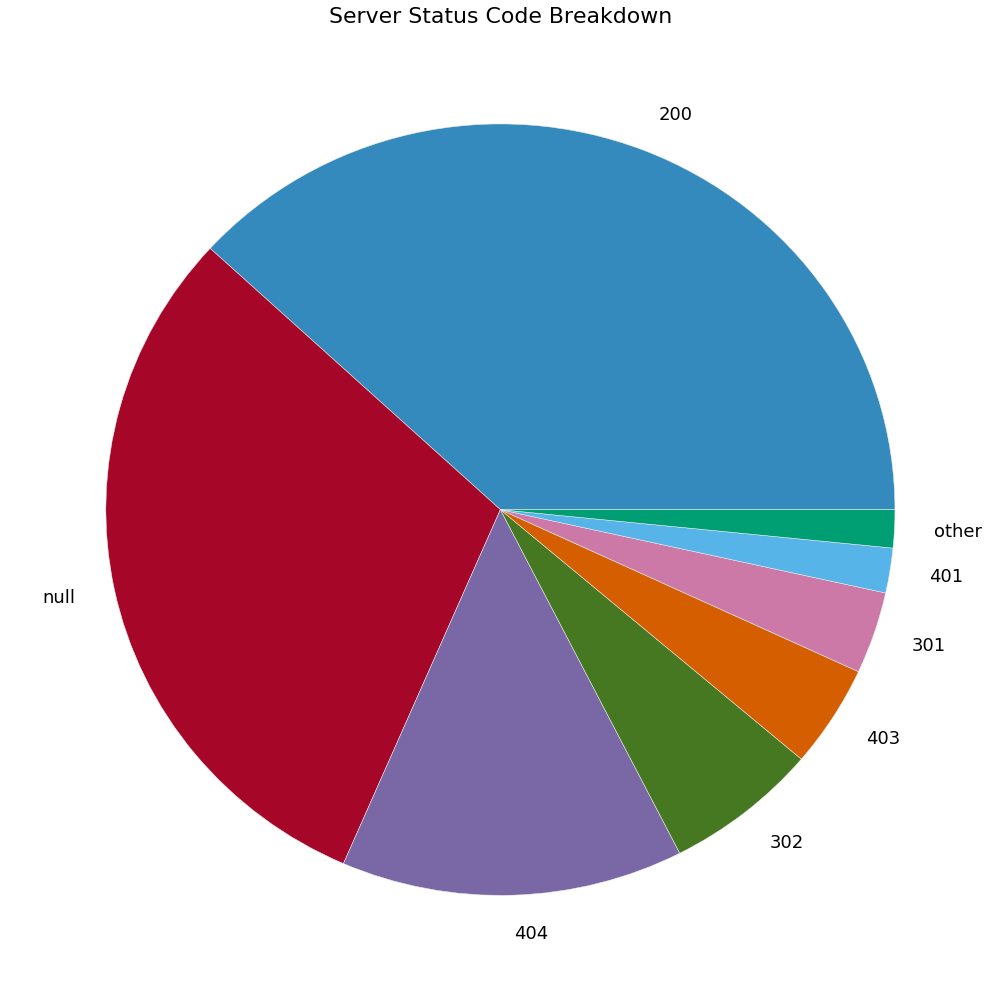

In [19]:
# Plot and save graph
ax = df_status.plot.pie(x='',figsize=(14, 14), fontsize=18)
#ax.set_title('Server Status Code Breakdown', fontsize=22)
ax.set_ylabel('')
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('../figs/STATUS_FREQUENCY.png')